# Advanced usage example for the `mn_squared` package

In this notebook, we show how to:

- Compare **several candidate models at once** (multiple null hypotheses).
- Evaluate **many datasets in a batch** instead of one-by-one.
- Use simulation to estimate **operating characteristics**:
  - Type I error (false alarm probability, $\alpha$),
  - Type II error (missed detection probability, $\beta$),
  - Family-wise error rate (FWER).
- Compare different internal backends (`exact`, `mc_multinomial`, `mc_normal`).

If you just want to plug in one observed histogram and get p-values and a decision, start with ``example_initial.py`` instead.
This example is for *planning* and *evaluating* a study design:
“How often will this test be right or wrong under different scenarios?”

## Scenario

We consider a categorical outcome with three categories, e.g.:

1. **Support**,
2. **Neutral**,
3. **Oppose**.

We fix a total sample size of $n = 20$ per histogram and define three candidate
null distributions over these categories:

- $\mathcal{H}_0^1: \mathbf{p}_1 = (0.50, 0.30, 0.20)$,
- $\mathcal{H}_0^2: \mathbf{p}_2 = (0.60, 0.25, 0.15)$,
- $\mathcal{H}_0^3: \mathbf{p}_3 = (0.30, 0.30, 0.40)$.

Each null has the same target significance level $\alpha_\ell = 0.05$.
The test either selects one of $\mathcal{H}_0^1, \mathcal{H}_0^2, \mathcal{H}_0^3$ or rejects all of them in
favor of a generic alternative: $\mathcal{H}_1$.


Formally, for a decision rule $\varphi_n(\cdot)$ applied to a random histogram ($\mathbf{H}$) of $n$ realizations generated under $\mathcal{H}_0^{\ell}$:

- The **Type I error** for null $\mathcal{H}_0^{\ell}$ is
  $$\alpha_{n,\ell} = \mathbb{P}(\varphi_n(\mathbf{H}) = -1 \mid \mathcal{H}_0^{\ell}),$$
  i.e., the probability that we reject all nulls when in fact $\mathcal{H}_0^\ell$ is correct.
- For a fixed alternative distribution $\mathbf{q}$ (whose hypothesis is denoted as $\mathcal{H}_1^{\mathbf{q}}$), the **Type II error** is
  $$\beta_n^{\mathbf{q}} = \mathbb{P}(\varphi_n(H) \in [L] \mid \mathcal{H}_1^{\mathbf{q}}),$$
  i.e., the probability that the procedure accepts at least one null when data
  are generated from the alternative.


## Imports and helper functions

We first import NumPy, Matplotlib, and `MNSquaredTest`. We then define
a few helper functions for simulation.


In [1]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt

from mn_squared import MNSquaredTest

In [2]:
def simulate_decisions(
    test: MNSquaredTest,
    generating_probs: list[float],
    n: int,
    mc_replications: int,
    rng_gen: np.random.Generator,
) -> np.ndarray:
    """
    Simulate `n_replications` histograms from a multinomial model with given probabilities and feed them to
    `test.infer_decisions`.

    Parameters
    ----------
    test
        A configured :class:`MNSquaredTest` instance.
    generating_probs
        Probabilities used to generate synthetic data (length = prob_dim).
    n
        Total count per histogram (must match the `evidence_size` used when building `test`).
    mc_replications
        Number of Monte Carlo replications.
    rng_gen
        NumPy random Generator for reproducibility.

    Returns
    -------
    np.ndarray
        1D array of decision codes (shape: (n_replications,)), where each entry is:

        -1           → all null hypotheses rejected (alternative chosen)
         k ≥ 1       → index (1-based) of selected null hypothesis
    """
    h_batch = rng_gen.multinomial(
        n=n,
        pvals=np.asarray(generating_probs, dtype=float),
        size=mc_replications,
    )
    decisions = test.infer_decisions(hist_query=h_batch)
    # Ensure we always work with a flat NumPy array of ints.
    return np.asarray(a=decisions, dtype=int).reshape(-1)


def estimate_alpha_for_null(
    test: MNSquaredTest,
    null_index: int,
    null_probs: list[list[float]],
    n: int,
    mc_replications: int,
    rng_gen: np.random.Generator,
) -> float:
    """
    Empirical estimate of α_{n,ℓ} = P(φ_n(H) = -1 | H_ℓ is true).

    Parameters
    ----------
    test
        A configured :class:`MNSquaredTest` instance.
    null_index
        Index (1-based) of the null hypothesis to evaluate.
    null_probs
        List of probability vectors for each null hypothesis.
    n
        Total count per histogram (must match the `evidence_size` used when building `test`).
    mc_replications
        Number of Monte Carlo replications.
    rng_gen
        NumPy random Generator for reproducibility.

    Returns
    -------
    float
        Empirical estimate of alpha_ℓ.
    """
    generating_probs = null_probs[null_index - 1]
    decisions = simulate_decisions(
        test=test,
        generating_probs=generating_probs,
        n=n,
        mc_replications=mc_replications,
        rng_gen=rng_gen,
    )

    empirical_alpha = float(np.mean(decisions == -1))
    return empirical_alpha


def estimate_beta(
    test: MNSquaredTest,
    alt_probs: list[float],
    n: int,
    mc_replications: int,
    rng_gen: np.random.Generator,
) -> float:
    """
    Empirical estimate of β_n^q = P(φ_n(H) ∈ [L] | p = q_alt).

    Parameters
    ----------
    test
        A configured :class:`MNSquaredTest` instance.
    alt_probs
        Probability vector for the alternative distribution.
    n
        Total count per histogram (must match the `evidence_size` used when building `test`).
    mc_replications
        Number of Monte Carlo replications.
    rng_gen
        NumPy random Generator for reproducibility.

    Returns
    -------
    float
        Empirical estimate of beta.
    """
    decisions = simulate_decisions(
        test=test,
        generating_probs=alt_probs,
        n=n,
        mc_replications=mc_replications,
        rng_gen=rng_gen,
    )

    empirical_beta = float(np.mean(decisions != -1))
    return empirical_beta

## Define null hypotheses and build test objects

We now instantiate the test with three different backends:

- Exact (`exact`),
- Monte Carlo multinomial (`mc_multinomial`),
- Normal approximation (`mc_normal`).


In [3]:
rng: np.random.Generator = np.random.default_rng(seed=42)

categories: list[str] = ["Support", "Neutral", "Oppose"]
prob_dim: int = len(categories)
evidence_size: int = 20

null_labels: list[str] = [
    "H1: Baseline (50% support, 30% neutral, 20% oppose)",
    "H2: More support (60% support, 25% neutral, 15% oppose)",
    "H3: More opposition (30% support, 30% neutral, 40% oppose)",
]

null_probabilities: list[list[float]] = [
    [0.50, 0.30, 0.20],  # H1
    [0.60, 0.25, 0.15],  # H2
    [0.30, 0.30, 0.40],  # H3
]

target_alphas: list[float] = [0.05, 0.05, 0.05]
alternative_probs: list[float] = [0.20, 0.50, 0.30]

# Exact backend (feasible here because n=20 and prob_dim=3)
test_exact = MNSquaredTest(
    evidence_size=evidence_size,
    prob_dim=prob_dim,
    cdf_method="exact",
)

# Monte Carlo backend (recommended for larger sample sizes)
test_mc = MNSquaredTest(
    evidence_size=evidence_size,
    prob_dim=prob_dim,
    cdf_method="mc_multinomial",
    mc_samples=20_000,
    seed=0,
)

# Normal (CLT) backend
test_normal = MNSquaredTest(
    evidence_size=evidence_size,
    prob_dim=prob_dim,
    cdf_method="mc_normal",
    mc_samples=20_000,
    seed=0,
)

for probs, alpha in zip(null_probabilities, target_alphas, strict=True):
    test_normal.add_nulls(prob_vector=probs, target_alpha=alpha)
    test_mc.add_nulls(prob_vector=probs, target_alpha=alpha)
    test_exact.add_nulls(prob_vector=probs, target_alpha=alpha)

## Batched evaluation under $\mathcal{H}_1$ (Monte Carlo backend)

We generate a batch of histograms under $\mathcal{H}_1$ using a multinomial model
and evaluate them with the Monte Carlo backend.


In [4]:
batch_size: int = 8
print("=== MNSquaredTest example: batched evaluation & operating characteristics ===\n")
print(f"Generating a batch of {batch_size} histograms under H1...")

hist_batch = rng.multinomial(
    n=evidence_size,
    pvals=np.asarray(null_probabilities[0], dtype=float),
    size=batch_size,
)

p_values_batch = test_mc.infer_p_values(hist_query=hist_batch)
decisions_batch = np.asarray(test_mc.infer_decisions(hist_query=hist_batch), dtype=int).reshape(-1)

print("\nBatched results (Monte Carlo backend):")
print("Row | Histogram [Support, Neutral, Oppose] | Decision | p-values per null [H1, H2, H3]")
print("----+--------------------------------------+----------+-------------------------------")
for idx in range(batch_size):
    hist = hist_batch[idx]
    decision_code = decisions_batch[idx]
    p_row = np.asarray(p_values_batch[idx], dtype=float)
    hist_str = f"[{hist[0]:2d}, {hist[1]:2d}, {hist[2]:2d}]"
    p_str = ", ".join(f"{p_val:0.4f}" for p_val in p_row)
    print(f"{idx:3d} | {hist_str:36s} | {decision_code:8d} | [{p_str}]")

=== MNSquaredTest example: batched evaluation & operating characteristics ===

Generating a batch of 8 histograms under H1...

Batched results (Monte Carlo backend):
Row | Histogram [Support, Neutral, Oppose] | Decision | p-values per null [H1, H2, H3]
----+--------------------------------------+----------+-------------------------------
  0 | [12,  5,  3]                         |        2 | [0.7007, 1.0000, 0.0242]
  1 | [12,  4,  4]                         |        2 | [0.5657, 0.7760, 0.0323]
  2 | [ 7,  4,  9]                         |        3 | [0.0647, 0.0260, 0.6429]
  3 | [12,  4,  4]                         |        2 | [0.5657, 0.7760, 0.0323]
  4 | [ 7,  8,  5]                         |        1 | [0.4439, 0.1006, 0.3875]
  5 | [ 9,  4,  7]                         |        3 | [0.3064, 0.1212, 0.3591]
  6 | [11,  4,  5]                         |        1 | [0.5919, 0.5368, 0.1202]
  7 | [10,  7,  3]                         |        1 | [0.7628, 0.6275, 0.0428]


### Visualizing the batch

We can also visualize the histograms in the batch and the p-values per null.


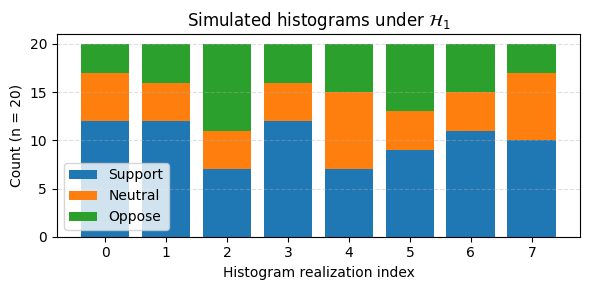

In [5]:
# Simple visualization: stacked bar of histograms
_, ax = plt.subplots(figsize=(6, 3))
ax:plt.Axes
x = np.arange(batch_size)
hist_support = hist_batch[:, 0]
hist_neutral = hist_batch[:, 1]
hist_oppose = hist_batch[:, 2]

ax.bar(x=x, height=hist_support, label="Support")
ax.bar(x=x, height=hist_neutral, bottom=hist_support, label="Neutral")
ax.bar(x=x, height=hist_oppose, bottom=hist_support + hist_neutral, label="Oppose")
ax.set_xlabel(xlabel="Histogram realization index")
ax.set_ylabel(ylabel="Count (n = 20)")
ax.set_title(label="Simulated histograms under $\\mathcal{H}_1$")
ax.set_xticks(ticks=x)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()


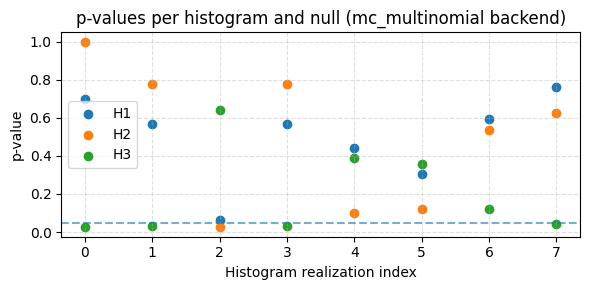

In [6]:
# Visualization of p-values for each row and null
_, ax = plt.subplots(figsize=(6, 3))
x = np.arange(batch_size)
p_vals_np = np.asarray(p_values_batch, dtype=float)

for j in range(p_vals_np.shape[1]):
    ax.scatter(x, p_vals_np[:, j], marker="o", label=f"H{j+1}")

ax.set_xlabel(xlabel="Histogram realization index")
ax.set_ylabel(ylabel="p-value")
ax.set_title(label="p-values per histogram and null (mc_multinomial backend)")
ax.axhline(y=0.05, linestyle="--", alpha=0.6)
ax.grid(visible=True, linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

## Compare backends on a single histogram

We now pick a single histogram from the batch and compare the p-values
            obtained with the three backends.


In [7]:
test_hist = hist_batch[0]
print("\nComparing backends for a single histogram:")
print(f"  Histogram: {test_hist.tolist()}")

p_normal = np.asarray(a=test_normal.infer_p_values(hist_query=test_hist), dtype=float).reshape(-1)
p_mc = np.asarray(a=test_mc.infer_p_values(hist_query=test_hist), dtype=float).reshape(-1)
p_exact = np.asarray(a=test_exact.infer_p_values(hist_query=test_hist), dtype=float).reshape(-1)

print("  p-values (mc_normal)     :", ", ".join(f"{v:0.6f}" for v in p_normal))
print("  p-values (mc_multinomial):", ", ".join(f"{v:0.6f}" for v in p_mc))
print("  p-values (exact)         :", ", ".join(f"{v:0.6f}" for v in p_exact))


Comparing backends for a single histogram:
  Histogram: [12, 5, 3]
  p-values (mc_normal)     : 0.699800, 1.000000, 0.038600
  p-values (mc_multinomial): 0.700650, 1.000000, 0.024200
  p-values (exact)         : 0.701706, 1.000000, 0.022766


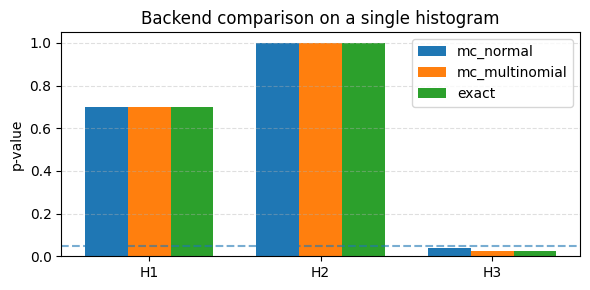

In [8]:
# Visual comparison of p-values across backends
labels = ["H1", "H2", "H3"]
x = np.arange(len(labels))

_, ax = plt.subplots(figsize=(6, 3))
width = 0.25
ax.bar(x=x - width, height=p_normal, width=width, label="mc_normal")
ax.bar(x=x, height=p_mc, width=width, label="mc_multinomial")
ax.bar(x=x + width, height=p_exact, width=width, label="exact")

ax.set_xticks(ticks=x)
ax.set_xticklabels(labels=labels)
ax.set_ylabel(ylabel="p-value")
ax.set_title(label="Backend comparison on a single histogram")
ax.axhline(y=0.05, linestyle="--", alpha=0.6)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()


## Empirical alpha, beta, and FWER

Finally, we estimate:

- The Type I error for each null ($\alpha_\ell$) using simulation under $H_\ell$.
- The Type II error ($\beta$) under a fixed alternative distribution.
- The family-wise error rate (FWER) from the exact backend.


In [9]:
n_replications: int = 5_000

print("\nEstimating operating characteristics via simulation "
      f"(n_replications = {n_replications})...")
print()

alpha_hats: list[float] = []
alpha_theoretical_list: list[float] = []

for ell in range(1, len(null_probabilities) + 1):
    alpha_theoretical = float(test_exact.get_alpha(null_index=ell))
    alpha_hat = estimate_alpha_for_null(
        test=test_mc,
        null_index=ell,
        null_probs=null_probabilities,
        n=evidence_size,
        mc_replications=n_replications,
        rng_gen=rng,
    )

    alpha_theoretical_list.append(alpha_theoretical)
    alpha_hats.append(alpha_hat)

    print(f"For {null_labels[ell - 1]}")
    print(f"  Target alpha:  {target_alphas[ell - 1]:0.4f}")
    print(f"  Theoretical alpha (Type I): {alpha_theoretical:0.4f}")
    print(f"  Empirical alpha (Type I): {alpha_hat:0.4f}")
    print()

beta_theoretical = float(test_exact.get_beta(prob_query=alternative_probs))
beta_hat = estimate_beta(
    test=test_mc,
    alt_probs=alternative_probs,
    n=evidence_size,
    mc_replications=n_replications,
    rng_gen=rng,
)

print(f"For an alternative: {alternative_probs}")
print(f"  Theoretical beta (Type II vs alt={alternative_probs}): {beta_theoretical:0.4f}")
print(f"  Empirical beta  (Type II vs alt={alternative_probs}): {beta_hat:0.4f}")
print()

alpha_star = test_exact.get_fwer()
print(f"Family-wise error rate (FWER) of the test: {alpha_star:0.4f}")



Estimating operating characteristics via simulation (n_replications = 5000)...

For H1: Baseline (50% support, 30% neutral, 20% oppose)
  Target alpha:  0.0500
  Theoretical alpha (Type I): 0.0212
  Empirical alpha (Type I): 0.0214

For H2: More support (60% support, 25% neutral, 15% oppose)
  Target alpha:  0.0500
  Theoretical alpha (Type I): 0.0464
  Empirical alpha (Type I): 0.0486

For H3: More opposition (30% support, 30% neutral, 40% oppose)
  Target alpha:  0.0500
  Theoretical alpha (Type I): 0.0309
  Empirical alpha (Type I): 0.0342

For an alternative: [0.2, 0.5, 0.3]
  Theoretical beta (Type II vs alt=[0.2, 0.5, 0.3]): 0.6933
  Empirical beta  (Type II vs alt=[0.2, 0.5, 0.3]): 0.6928

Family-wise error rate (FWER) of the test: 0.0464


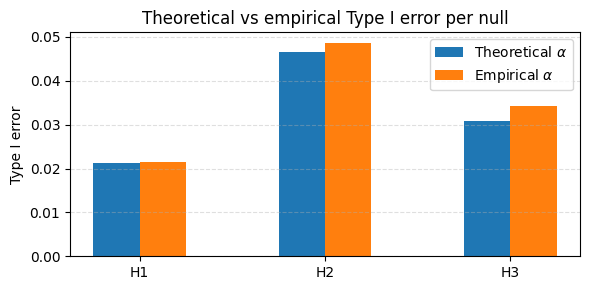

In [10]:
# Visual comparison of theoretical vs empirical alpha and beta
labels = ["H1", "H2", "H3"]
x = np.arange(len(labels))
alpha_theoretical_np = np.asarray(a=alpha_theoretical_list, dtype=float)
alpha_hat_np = np.asarray(a=alpha_hats, dtype=float)

_, ax = plt.subplots(figsize=(6, 3))
width = 0.25
ax.bar(x=x - width/2, height=alpha_theoretical_np, width=width, label="Theoretical $\\alpha$")
ax.bar(x=x + width/2, height=alpha_hat_np, width=width, label="Empirical $\\alpha$")
ax.set_xticks(ticks=x)
ax.set_xticklabels(labels=labels)
ax.set_ylabel(ylabel="Type I error")
ax.set_title(label="Theoretical vs empirical Type I error per null")
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

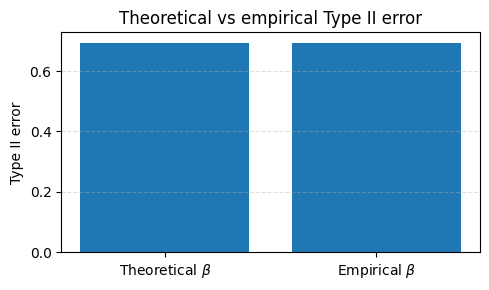

In [11]:
_, ax = plt.subplots(figsize=(5, 3))
ax.bar(x=[0, 1], height=[beta_theoretical, beta_hat])
ax.set_xticks(ticks=[0, 1])
ax.set_xticklabels(labels=["Theoretical $\\beta$", "Empirical $\\beta$"])
ax.set_ylabel(ylabel="Type II error")
ax.set_title(label="Theoretical vs empirical Type II error")
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


You can now tailor:

- the null distributions,
- the alternative distribution,
- the sample size `n`,
- the number of replications `mc_replications`,
- and the backends,

to match your own study design and planning questions.
